In [1]:
# !python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
# !python -c "import matplotlib" || pip install -q matplotlib
# %matplotlib inline

In [39]:
import os
import shutil
import h5py
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    NormalizeIntensity,
    AddChannel,
    ToTensor,
    MapTransform
)
from monai.utils import set_determinism

In [4]:
root_dir = '/home/polina/projects/test'
data_dir = os.path.join(root_dir, "data")

In [5]:
set_determinism(seed=0)

## Exploring the dataset: visualization and calculation of statistics

In [6]:
datah5py = h5py.File(os.path.join(data_dir, 'plane_classification'))
datah5py.keys()
label_names = {1:'too Deep', 2: 'optimal (“Good”)', 3: 'too Shallow', 4: 'bad interface'}
img, plane_id, sub_id, y = [datah5py[k] for k in datah5py.keys()] 
class_names, num_each = np.unique(y, return_counts=True)
num_sub = len(np.unique(sub_id))
print(f"Total image count: {img.shape[0]}")
print(f"Total subject count: {num_sub}")
print(f"Image dimensions: {img.shape[1]} x {img.shape[2]}")
print(f"Label names: {class_names} \n {label_names}")
print(f"Label counts: {num_each}")

Total image count: 7655
Total subject count: 431
Image dimensions: 256 x 256
Label names: [1 2 3 4] 
 {1: 'too Deep', 2: 'optimal (“Good”)', 3: 'too Shallow', 4: 'bad interface'}
Label counts: [2766  928 1731 2230]


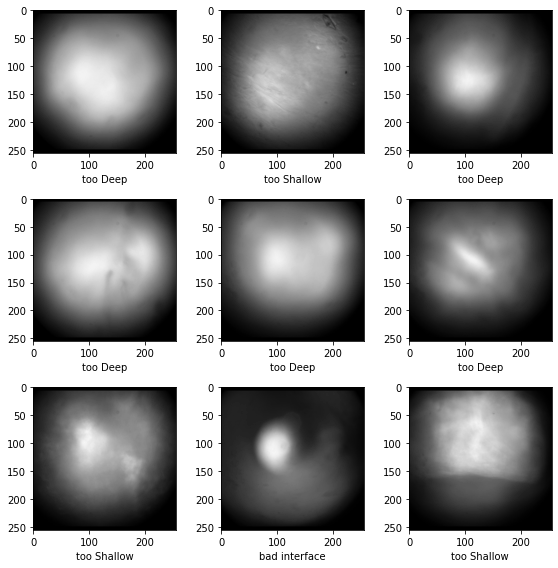

In [7]:
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(img.shape[0], size=9)):
    arr = img[k]
    plt.subplot(3, 3, i + 1)
    plt.xlabel(label_names[y[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

Encoding labels - counting from 0 class

In [8]:
l_t = LabelEncoder()
y_label_encoding = l_t.fit_transform(y)

In [9]:
np.unique(y_label_encoding, return_counts=True)

(array([0, 1, 2, 3]), array([2766,  928, 1731, 2230]))

## Prepare training, validation and test data lists; Define dataset and Dataloader to pre-process data

In [10]:
X_train, X_test, y_train, y_test = train_test_split(np.array(img), np.array(y_label_encoding), 
                                                    train_size=0.7, 
                                                    random_state=42,
                                                    stratify=np.array(y_label_encoding))
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, 
                                                    train_size=0.5, 
                                                    random_state=42,
                                                    stratify=y_test)

print(f"y_train : {np.bincount(y_train)}")
print(f"y_val: {np.bincount(y_val)}")
print(f"y_test: {np.bincount(y_test)}")

y_train : [1936  649 1212 1561]
y_val: [415 139 260 335]
y_test: [415 140 259 334]


In [48]:
train_transforms = Compose(
    [
        AddChannel(), 
#         ScaleIntensity(),
#         NormalizeIntensity(), 
        ToTensor()
#         ScaleIntensity(),
#         RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
#         RandFlip(spatial_axis=0, prob=0.5),
#         RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ]
)

val_transforms = Compose(
    [AddChannel(), ToTensor()])
#      , ScaleIntensity()])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=len(class_names))])

In [49]:
class PlaneDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]


train_ds = PlaneDataset(X_train, y_train, train_transforms)
train_loader = DataLoader(
    train_ds, batch_size=128, shuffle=True, num_workers=10)

val_ds = PlaneDataset(X_val, y_val, val_transforms)
val_loader = DataLoader(
    val_ds, batch_size=64, num_workers=10)

test_ds = PlaneDataset(X_test, y_test, val_transforms)
test_loader = DataLoader(
    test_ds, batch_size=64, num_workers=10)

## Define network and optimizer -> training

In [15]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = DenseNet121(spatial_dims=2, in_channels=1,
                    out_channels=len(class_names)).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()

In [22]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(torch.long).to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

----------
epoch 1/100
1/41, train_loss: 1.3760
2/41, train_loss: 1.3611
3/41, train_loss: 1.3421
4/41, train_loss: 1.3220
5/41, train_loss: 1.3162
6/41, train_loss: 1.3081
7/41, train_loss: 1.2757
8/41, train_loss: 1.2671
9/41, train_loss: 1.2480
10/41, train_loss: 1.2707
11/41, train_loss: 1.2730
12/41, train_loss: 1.2096
13/41, train_loss: 1.2042
14/41, train_loss: 1.2178
15/41, train_loss: 1.1986
16/41, train_loss: 1.1886
17/41, train_loss: 1.1815
18/41, train_loss: 1.1849
19/41, train_loss: 1.1514
20/41, train_loss: 1.1481
21/41, train_loss: 1.1351
22/41, train_loss: 1.0986
23/41, train_loss: 1.1128
24/41, train_loss: 1.1318
25/41, train_loss: 1.0987
26/41, train_loss: 1.0942
27/41, train_loss: 1.1375
28/41, train_loss: 1.1165
29/41, train_loss: 1.0681
30/41, train_loss: 1.0599
31/41, train_loss: 1.0759
32/41, train_loss: 1.0495
33/41, train_loss: 1.0897
34/41, train_loss: 0.9762
35/41, train_loss: 1.0786
36/41, train_loss: 1.0232
37/41, train_loss: 1.0056
38/41, train_loss: 1.036

## Plot the loss and metric

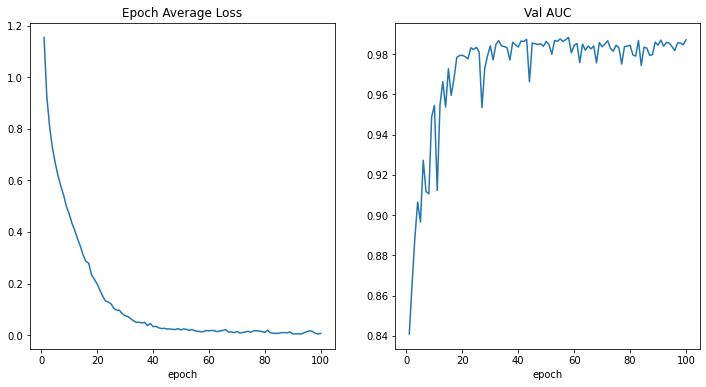

In [23]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Evaluate the model on test dataset

In [24]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [34]:
name_lab = ['too Deep', 'optimal (“Good”)', 'too Shallow', 'bad interface']
name_dict = {0:'too Deep',1: 'optimal (“Good”)', 2:'too Shallow', 3:'bad interface'}

In [28]:
print(classification_report(
    y_true, y_pred, target_names=name_lab))

                  precision    recall  f1-score   support

        too Deep       0.95      0.95      0.95       415
optimal (“Good”)       0.81      0.79      0.80       140
     too Shallow       0.91      0.88      0.89       259
   bad interface       0.97      0.98      0.97       334

        accuracy                           0.93      1148
       macro avg       0.91      0.90      0.91      1148
    weighted avg       0.93      0.93      0.93      1148



<AxesSubplot:>

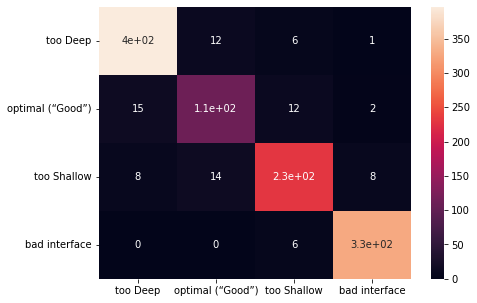

In [39]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true, y_pred)).rename(columns=name_dict, index=name_dict)
fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)

In [40]:
confusion_matrix_df

,too Deep,optimal (“Good”),too Shallow,bad interface
too Deep,396,12,6,1
optimal (“Good”),15,111,12,2
too Shallow,8,14,229,8
bad interface,0,0,6,328
